# Create Neo4j Database

### Retrieve Required Data

In [1]:
import pandas as pd
import pickle
import numpy as np
import re
import string
import matplotlib.pyplot as plt

In [2]:
def normalize_text(text):
    # Lowercase every words
    text = text.lower()
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [3]:
# User comedian matrix
matrix_filename = 'user_comedian_matrix_OriginalPolarity.pkl'
ucm_df = pd.read_pickle(matrix_filename)
ucm_df.index = [normalize_text(t) for t in ucm_df.index]
ucm_df.columns = [normalize_text(t) for t in ucm_df.columns]
ucm_df

,ramy youssef,andy woodhull,amy schumer,arsenio hall,aziz ansari,bert kreischer,bill burr,chris delia,chris rock,dave chappelle,...,ronny chieng,roy wood jr,russell peters,sebastian maniscalco,tiffany haddish,tom segura,trevor noah,urzila carlson,vir das,whitney cummings
a b,0.191429,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
adedotun akande,NaN,0.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.4,NaN,-0.1625,NaN,NaN,NaN,NaN,NaN,NaN
anton nym,NaN,0.68099,NaN,NaN,NaN,0,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lydia wawerumorgan,NaN,-0.2375,NaN,0.65,NaN,0.488281,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jennifer bates,NaN,0.671875,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
camthedestroyer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jay jay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN
cynthia copland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.3,NaN,NaN,NaN,NaN,NaN
comedy central standup comedy central standup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.268182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5


In [4]:
# Comedian Properties
cp_df = pd.read_excel('ComedianProperties.xlsx')
# Categorize the year of birth of the comedians
cp_df['year group'] = cp_df.year.apply(lambda x: str(x)[:3]+'0s')
# Remove unnecessary columns
cp_df = cp_df.drop(['spouseLabel','children_number','birthdate','year'], axis=1)
# change column names
cp_df.columns = ['Comedian','Citizenship','Ethnicity','Married','Gender','Year']
# Normalize comedian names
cp_df.Comedian = cp_df['Comedian'].apply(normalize_text)
# Set index to comedian
cp_df = cp_df.set_index(cp_df['Comedian'])
cp_df.head()

,Comedian,Citizenship,Ethnicity,Married,Gender,Year
Comedian,,,,,,
andy woodhull,andy woodhull,United States of America,White,True,male,1980s
ramy youssef,ramy youssef,United States of America,Egyptian-American Muslim,False,male,1990s
amy schumer,amy schumer,United States of America,American Jews,True,female,1980s
arsenio hall,arsenio hall,United States of America,African Americans,False,male,1950s
aziz ansari,aziz ansari,United States of America,Tamil American,False,male,1980s


In [5]:
# Comedian & keywords
kw_df = pd.read_excel('keywords_clean.xlsx',index_col=0)
kw_df.Comedian = kw_df.Comedian.apply(normalize_text)
kw_df.head()

,Comedian,Keywords
0,amy schumer,"grow, grows, arrested, schumers, schumer, butt..."
1,andy woodhull,"toast, maze, punishing, punishment, ordered pu..."
2,arsenio hall,"wesley, marching, tiger, grow, plus, bernie, a..."
3,aziz ansari,"randy, randys, harris, texted, writing, writes..."
4,bert kreischer,"marshmallow, leeann, ilas, pajama, glock, leea..."


In [6]:
# Users and Comedians 
users = ucm_df.index
comedians = list(map(str.lower, ucm_df.columns))

### Build the graph in neo4j

In [7]:
from py2neo import Graph, Node, Relationship

In [8]:
host = "localhost"
password = "0000"
graph = Graph(host=host, password=password)

In [9]:
# Delete all nodes and relationships
DELETE_QUERY = "MATCH (n) DETACH DELETE n"
_ = graph.run(DELETE_QUERY)

In [10]:
# Add all user nodes
for user in users:
    graph.run("""
    MERGE (:User{name: $user})
    """, user=user)

In [11]:
# Add all comedian nodes
for comedian in comedians:
    properties = cp_df.loc[comedian]
    graph.run("""
    MERGE (:Comedian{name: $comedian, 
                      ethnicity: $ethnicity,
                      married: $married,
                      gender: $gender,
                      year: $year})
        """,comedian=comedian,
            citizenship=properties['Citizenship'],
            ethnicity=properties['Ethnicity'],
            married=int(properties['Married']),
            gender=properties['Gender'],
            year=properties['Year'])

In [12]:
# Build relationships for users and comedians
for c in ucm_df.columns:
    for u in ucm_df[c].keys():  
        rating = ucm_df.loc[u, c]
        if rating != 'NaN':
            graph.run("""
            MATCH (u:User{name: $user})
            MATCH (c:Comedian{name: $comedian})
            MERGE (u)-[r:commented_on{rating: $rr}]->(c)""", user=u, comedian=c.lower(), rr=rating)

In [13]:
# Add all keyword nodes
for i, r in kw_df.iterrows():
    comedian = r.Comedian
    keywords = r.Keywords.split(',')
    for word in keywords:
        graph.run("""
        MERGE (k:Keyword{word: $word})
        """, word=word)
        graph.run("""
        MATCH (c:Comedian{name: $comedian})
        MATCH (k:Keyword{word: $word})
        MERGE (c)-[:has_keyword]->(k)""", comedian=comedian, word=word)

# Clustering

In [15]:
from igraph import Graph as IGraph

In [19]:
query="""
MATCH (k1:Keyword)<-[:has_keyword]-()-[:has_keyword]->(k2:Keyword)
WHERE ID(k1) < ID(k2)
RETURN k1.word, k2.word, COUNT(*) as weight
ORDER BY weight DESC
LIMIT 10
"""

result = graph.run(query)
for row in result:
    print(row)

' shes'	' fucking'	22
' shes'	' thanks'	21
' shes'	' life'	21
' thanks'	' fucking'	21
' fucking'	' kid'	20
' fucking'	' life'	20
' fucking'	' person'	19
' work'	' person'	19
' thanks'	' work'	19
' woman'	' everybody'	19


In [20]:
query = """
MATCH (k1:Keyword)<-[:has_keyword]-()-[:has_keyword]->(k2:Keyword)
WHERE ID(k1) < ID(k2)
RETURN k1.word, k2.word, COUNT(*) as weight
"""

ig = IGraph.TupleList(graph.run(query), weights=True)
ig

In [21]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

8

In [22]:
nodes = [node["name"] for node in ig.vs]
nodes = [{"id": x, "label": x} for x in nodes]
nodes[:5]

for node in nodes:
    idx = ig.vs.find(name=node["id"]).index
    node["group"] = clusters.membership[idx]
    
nodes[:5]

[{'id': ' chip', 'label': ' chip', 'group': 0},
 {'id': ' uh look', 'label': ' uh look', 'group': 0},
 {'id': ' dad thats bit', 'label': ' dad thats bit', 'group': 0},
 {'id': ' wife waiting', 'label': ' wife waiting', 'group': 0},
 {'id': ' sausage', 'label': ' sausage', 'group': 0}]

In [27]:
pickle.dump(nodes, open('keyword_group.pkl', 'wb'))

# Prediction

In [14]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [15]:
# Load training and test dataset
train_df = pd.read_csv('training_set.csv', index_col=0)
test_df = pd.read_csv('test_set.csv', index_col=0)

In [16]:
train_df.Name = train_df.Name.apply(normalize_text)
train_df.Comedian = train_df.Comedian.apply(normalize_text)
test_df.Name = test_df.Name.apply(normalize_text)
test_df.Comedian = test_df.Comedian.apply(normalize_text)

### Apply node2vec

In [17]:
query = "CALL gds.graph.drop('MyGraph')"
graph.run(query)

query = "CALL gds.graph.create('MyGraph', '*', '*')"
graph.run(query)

 nodeProjection                          | relationshipProjection                                                                 | graphName | nodeCount | relationshipCount | createMillis 
-----------------------------------------|----------------------------------------------------------------------------------------|-----------|-----------|-------------------|--------------
 {__ALL__: {properties: {}, label: '*'}} | {__ALL__: {orientation: 'NATURAL', aggregation: 'DEFAULT', type: '*', properties: {}}} | MyGraph   |      6363 |              8689 |            7 

In [18]:
query="""
CALL gds.alpha.node2vec.stream(
'MyGraph',
{
  returnFactor: 1.0, // parameter 'p'
  inOutFactor: 2.0,  // parameter 'q'
  embeddingSize: 16  // parameter 'd'
})"""

embedding_df = graph.run(query).to_data_frame()
embedding_df = embedding_df.set_index('nodeId')
embedding_df.head()

,embedding
nodeId,
0,"[-0.4676918685436249, -0.10720621794462204, 0...."
1,"[0.7377662658691406, -0.8293171525001526, 0.40..."
2,"[0.43946054577827454, -0.5555458068847656, 0.9..."
3,"[0.09965423494577408, 0.40443798899650574, 0.0..."
4,"[-0.40323323011398315, -0.46323075890541077, 0..."


In [19]:
def get_embedding(node_id):
    return embedding_df.loc[node_id][0]

### Lookup nodeids and relationships

In [20]:
# Retrieve comedian-id lookup table
query = "MATCH (n:Comedian) RETURN ID(n) as c_id, n.name as name"

comedianID_df = graph.run(query).to_data_frame()
comedianID_df.head()

,c_id,name
0,731,ramy youssef
1,732,andy woodhull
2,733,amy schumer
3,734,arsenio hall
4,735,aziz ansari


In [21]:
# Retrieve user-id lookup table
query = "MATCH (n:User) RETURN ID(n) as u_id, n.name as name"

userID_df = graph.run(query).to_data_frame()
userID_df.head()

,u_id,name
0,532,a b
1,653,adedotun akande
2,654,anton nym
3,655,lydia wawerumorgan
4,656,jennifer bates


In [22]:
# Transplate the names in the dataset into id
for k, v in train_df.iterrows():
    user = v['Name']
    com = v['Comedian']
    train_df.iloc[k, 0] = userID_df[userID_df.name == user].u_id.values[0]
    train_df.iloc[k, 1] = comedianID_df[comedianID_df.name == com].c_id.values[0]
    
for k, v in test_df.iterrows():
    user = v['Name']
    com = v['Comedian']
    test_df.iloc[k, 0] = userID_df[userID_df.name == user].u_id.values[0]
    test_df.iloc[k, 1] = comedianID_df[comedianID_df.name == com].c_id.values[0]

In [23]:
# query all user-comedian id relationships and ratings
query = """
MATCH (u:User)-[r:commented_on]->(c:Comedian)
RETURN ID(u) as u_id, ID(c) as c_id, r.rating as y
"""
ucID_df = graph.run(query).to_data_frame()
ucID_df.head()

,u_id,c_id,y
0,532,731,0.191429
1,653,732,0.875000
2,654,732,0.680990
3,655,732,-0.237500
4,656,732,0.671875


In [24]:
# query all comedian-keyword id relationships
query = """
MATCH (c:Comedian)-[:has_keyword]->(k:Keyword)
WHERE ID(c) = $comedian_id
RETURN ID(c) as c_id, COLLECT(DISTINCT ID(k)) as k_id
"""
ckID_df = pd.DataFrame(columns=['c_id','k_id']) 
for cid in comedianID_df.c_id:
    result = graph.run(query, comedian_id=cid)
    for k, v in result:
        ckID_df = ckID_df.append({'c_id': k, 'k_id':v}, ignore_index=True)

In [25]:
len(ckID_df.c_id.unique())

40

In [26]:
# calculate the centroid of keywords for each 
k_centroid = []
for k, v in ckID_df.iterrows():
    vector = None
    for k_id in v['k_id']:
        if vector is None:
            vector = get_embedding(k_id)
        else:
            vector = np.add(get_embedding(k_id), vector)
    k_centroid.append(np.divide(vector, len(v['k_id'])))
ckID_df['k_centroid'] = k_centroid
ckID_df.head()

,c_id,k_id,k_centroid
0,731,"[6022, 6021, 6020, 6019, 5505, 6018, 6017, 601...","[0.00773896171670893, 0.02299525260763324, 0.0..."
1,732,"[1025, 1024, 1023, 981, 982, 983, 984, 985, 98...","[0.014331098397910271, 0.021742890345985474, -..."
2,733,"[980, 979, 978, 977, 976, 975, 974, 973, 972, ...","[0.05545345296905864, 0.012458343704098037, 0...."
3,734,"[1085, 1084, 1083, 1082, 1081, 1080, 1079, 107...","[-0.13222368947801091, -0.09775669109677115, -..."
4,735,"[1336, 1335, 1334, 1333, 1332, 1331, 1330, 132...","[0.021162932835376035, 0.014065117802685843, 0..."


In [28]:
ucID_df['tuple'] = [(v['u_id'], v['c_id']) for k, v in ucID_df.iterrows()]
ucID_df.head()

,u_id,c_id,y,tuple
0,532,731,0.191429,"(532.0, 731.0)"
1,653,732,0.875000,"(653.0, 732.0)"
2,654,732,0.680990,"(654.0, 732.0)"
3,655,732,-0.237500,"(655.0, 732.0)"
4,656,732,0.671875,"(656.0, 732.0)"


In [34]:
def create_dataset(df):
    # Select data from ucID_df according to train_df or test_df
    selected_df= ucID_df[ucID_df['tuple'].isin([(v['Name'], v['Comedian']) for k, v in df.iterrows()])]
    selected_df = selected_df.drop('tuple', axis=1)
    
    # Merger this selected df with the ckID_df to append k_centroid
    merge_k_centroid = selected_df.merge(ckID_df,on='c_id')
    merge_k_centroid = merge_k_centroid.drop('k_id', axis=1)
    
    # Translate u_id and c_id to embedding
    merge_k_centroid.u_id = merge_k_centroid.u_id.apply(get_embedding)
    merge_k_centroid.c_id = merge_k_centroid.c_id.apply(get_embedding)
    
    # Expend all embeddings to columns
    temp_u = merge_k_centroid.u_id.apply(pd.Series)
    temp_u = temp_u.rename(columns = lambda x : 'u' + str(x))
    temp_c = merge_k_centroid.c_id.apply(pd.Series)
    temp_c = temp_c.rename(columns = lambda x : 'c' + str(x))
    temp_k = merge_k_centroid.k_centroid.apply(pd.Series)
    temp_k = temp_k.rename(columns = lambda x : 'k' + str(x))
    
    dataset = pd.concat([merge_k_centroid['y'], temp_u[:], temp_c[:], temp_k[:]], axis=1)
    return dataset    

In [63]:
train_dataset = create_dataset(train_df)
train_dataset.to_pickle('train_dataset.pkl')
train_dataset

,y,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,0.191429,0.802476,0.873645,-0.756069,0.117870,0.575198,0.822339,-0.362073,-0.049969,-0.902664,...,-0.212303,-0.066829,0.112213,0.069847,-0.021264,0.113460,0.004552,-0.135570,-0.156386,-0.099397
1,0.875000,-0.343719,0.290316,0.298702,0.483750,-0.327937,-0.602723,-0.791501,-0.119358,-0.528941,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
2,0.680990,-0.264831,-0.357274,-0.236613,-0.469278,0.728996,0.142204,0.237120,-0.675550,0.384564,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
3,-0.237500,-0.463751,-0.010341,-0.149908,-0.883300,0.398351,-0.888545,-0.928279,-0.715029,0.709560,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
4,0.671875,-0.548900,-0.688101,-0.434306,0.291519,-0.665596,0.373160,-0.409897,-0.392816,0.346474,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.446429,-0.019109,0.749876,0.183014,-0.915525,-0.177241,-0.204414,0.728615,-0.929565,0.625520,...,-0.087692,-0.046019,-0.031984,-0.046126,-0.003908,-0.013014,-0.030552,-0.113573,-0.034472,-0.064822
176,0.550000,0.824850,-0.498954,0.676385,0.934533,-0.812808,-0.979964,-0.140976,-0.733171,0.211605,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901
177,0.216667,0.424636,-0.554096,-0.407884,0.776823,0.094646,0.475762,0.761409,0.286781,-0.813350,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901
178,0.000000,0.779298,0.312822,0.690561,-0.959262,0.255044,0.589019,-0.888917,-0.736382,0.365568,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901


In [136]:
test_dataset = create_dataset(test_df)
test_dataset.to_pickle('test_dataset.pkl')
test_dataset

,y,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,-0.158333,0.089701,-0.345878,0.732003,-0.614563,0.121431,-0.579464,-0.783907,-0.467271,0.117587,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
1,0.650000,-0.463751,-0.010341,-0.149908,-0.883300,0.398351,-0.888545,-0.928279,-0.715029,0.709560,...,-0.190784,-0.097979,-0.150467,0.085909,0.097246,-0.018427,0.128919,0.118056,-0.018778,0.099433
2,0.254167,-0.239555,0.182769,-0.352681,-0.715806,0.861489,-0.805914,-0.549493,-0.219778,0.072557,...,-0.190784,-0.097979,-0.150467,0.085909,0.097246,-0.018427,0.128919,0.118056,-0.018778,0.099433
3,0.000000,0.824850,-0.498954,0.676385,0.934533,-0.812808,-0.979964,-0.140976,-0.733171,0.211605,...,-0.190784,-0.097979,-0.150467,0.085909,0.097246,-0.018427,0.128919,0.118056,-0.018778,0.099433
4,0.000000,0.424636,-0.554096,-0.407884,0.776823,0.094646,0.475762,0.761409,0.286781,-0.813350,...,-0.190784,-0.097979,-0.150467,0.085909,0.097246,-0.018427,0.128919,0.118056,-0.018778,0.099433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.200000,-0.602048,0.126685,-0.622228,0.272990,-0.538987,0.029484,-0.647592,-0.233483,0.171505,...,0.037675,0.045082,0.039657,0.027635,0.005951,0.009966,0.031877,0.086362,-0.002795,-0.060792
76,1.000000,-0.019109,0.749876,0.183014,-0.915525,-0.177241,-0.204414,0.728615,-0.929565,0.625520,...,0.078782,-0.022230,0.010557,-0.059698,0.078766,0.087289,0.022472,0.077721,-0.176548,-0.021536
77,0.214286,0.011117,0.256139,-0.332952,0.032229,0.763009,0.307893,0.110242,-0.249598,0.567304,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901
78,0.000000,0.330252,0.413034,0.359724,-0.416584,0.627703,0.055398,-0.042826,0.202273,0.357467,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901


## Train models

### Regression

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
train_dataset = pd.read_pickle('train_dataset.pkl')
test_dataset = pd.read_pickle('test_dataset.pkl')

In [5]:
X_train = train_dataset.values[:,1:]
Y_train = train_dataset.values[:,0]
X_test = test_dataset.values[:,1:]
Y_test = test_dataset.values[:,0]

In [6]:
measure = 'neg_mean_squared_error'

In [33]:
train_mse = []
test_mse = []
for i in range(1, 6):
    poly = PolynomialFeatures(degree = i)
    x_2 = poly.fit_transform(X_train)
    cv_poly = cross_val_score(LinearRegression(),x_2,Y_train, cv=KFold(n_splits = 3), scoring = measure)
    train_mse.append(-cv_poly.mean())
    
    lg = LinearRegression().fit(x_2, Y_train)
    pred = lg.predict(poly.fit_transform(X_test))
    test_mse.append(np.sum(np.power(pred - Y_test, 2)))

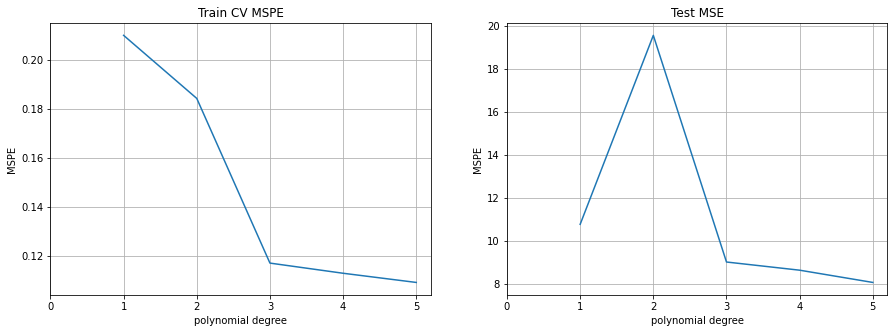

In [48]:
x = [i for i in range(1,6)]

fig = plt.figure(figsize=(15, 5))


plt.subplot(1,2,1)
plt.plot(x, train_mse)

x_range = range(0,6)
y_range = range(0,6)
plt.xticks(x_range, y_range)
plt.title('Train CV MSPE')
plt.xlabel('polynomial degree')
plt.ylabel('MSPE')
plt.grid()

plt.subplot(1,2,2)
plt.plot(x, test_mse)

x_range = range(0,6)
y_range = range(0,6)
plt.xticks(x_range, y_range)
plt.title('Test MSE')
plt.xlabel('polynomial degree')
plt.ylabel('MSPE')
plt.grid()

### Classification

In [121]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [51]:
train_dataset_cat = pd.read_pickle('train_dataset.pkl')
train_dataset_cat.y = train_dataset_cat.y.apply(lambda x: 1 if x > 0 else -1)
test_dataset_cat = pd.read_pickle('test_dataset.pkl')
test_dataset_cat.y = test_dataset_cat.y.apply(lambda x: 1 if x > 0 else -1)
train_dataset_cat

,y,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,0.802476,0.873645,-0.756069,0.117870,0.575198,0.822339,-0.362073,-0.049969,-0.902664,...,-0.212303,-0.066829,0.112213,0.069847,-0.021264,0.113460,0.004552,-0.135570,-0.156386,-0.099397
1,1,-0.343719,0.290316,0.298702,0.483750,-0.327937,-0.602723,-0.791501,-0.119358,-0.528941,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
2,1,-0.264831,-0.357274,-0.236613,-0.469278,0.728996,0.142204,0.237120,-0.675550,0.384564,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
3,-1,-0.463751,-0.010341,-0.149908,-0.883300,0.398351,-0.888545,-0.928279,-0.715029,0.709560,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
4,1,-0.548900,-0.688101,-0.434306,0.291519,-0.665596,0.373160,-0.409897,-0.392816,0.346474,...,0.119621,-0.057622,-0.006978,0.037528,0.075524,-0.066515,-0.032106,0.045462,-0.109129,0.044109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,-0.019109,0.749876,0.183014,-0.915525,-0.177241,-0.204414,0.728615,-0.929565,0.625520,...,-0.087692,-0.046019,-0.031984,-0.046126,-0.003908,-0.013014,-0.030552,-0.113573,-0.034472,-0.064822
176,1,0.824850,-0.498954,0.676385,0.934533,-0.812808,-0.979964,-0.140976,-0.733171,0.211605,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901
177,1,0.424636,-0.554096,-0.407884,0.776823,0.094646,0.475762,0.761409,0.286781,-0.813350,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901
178,-1,0.779298,0.312822,0.690561,-0.959262,0.255044,0.589019,-0.888917,-0.736382,0.365568,...,-0.027968,-0.030914,-0.004862,0.020798,0.009521,-0.036259,0.038028,0.010060,-0.002216,0.015901


In [57]:
X_train = train_dataset_cat.values[:,1:]
Y_train = train_dataset_cat.values[:,0]
X_test = test_dataset_cat.values[:,1:]
Y_test = test_dataset_cat.values[:,0]

#### SVM

In [72]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='auto'))
svc.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [66]:
svc.score(X_train, Y_train)

0.9944444444444445

In [67]:
svc.score(X_test, Y_test)

0.65

In [73]:
pre = []
for c in range(1,21):
    svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=c, gamma='auto'))
    kfold = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(svc,X_train,Y_train,cv=kfold,scoring="precision")
    pre.append(result.mean())

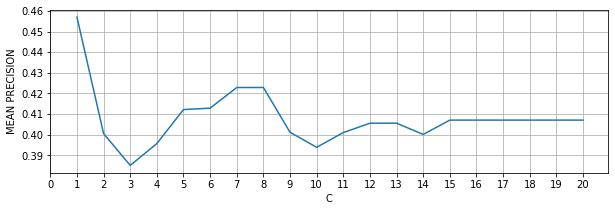

In [80]:
fig = plt.figure(figsize=(10,3))
plt.plot([x for x in range(1, 21)], pre)
x_range = range(0,21)
y_range = range(0,21)
plt.xlabel('C')
plt.ylabel('MEAN PRECISION')
plt.xticks(x_range, y_range)
plt.grid()

Good resource for SVM:

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

In [148]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.56


In [149]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma']))
svc.fit(X_train, Y_train)
svc.score(X_test, Y_test)

0.575

In [150]:
y_pred = svc.predict(X_test)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=svc.classes_, columns=svc.classes_)

,-1.0,1.0
-1.0,12,28
1.0,6,34


In [151]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.548
Recall = 0.850


#### Tree

#### Neural Network

ref: https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

In [266]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Accuracy
from keras.utils import np_utils
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

In [264]:
from keras.optimizers import SGD

In [270]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2,random_state=42)

In [364]:
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
metrics_cat = 'binary_accuracy'
metrics_reg = 'mae'

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [365]:
input_dim = len(X_train[0])

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer = sgd, loss = 'mse', metrics=[metrics_reg]) #root-mean-square, mae='mean absolute error'
history = model.fit(x_train, y_train, epochs = epochs, batch_size=1, validation_data=(x_test, y_test))

##
# model = Sequential()
# model.add(Dense(30, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
# model.add(Dense(30, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# model.compile(optimizer=sgd, 
#               loss='categorical_crossentropy', 
#               metrics=[metrics_cat])
# y_train = [0 if y == -1 else 1 for y in y_train]
# y_train2 = to_categorical(y_train)
# y_test = [0 if y == -1 else 1 for y in y_test]
# y_test2 = to_categorical(y_test)
# history = model.fit(x_train, y_train2, epochs = epochs, batch_size=1, validation_data=(x_test, y_test2))
##


Train on 144 samples, validate on 36 samples
Epoch 1/20
144/144 [==============================] - 0s 986us/step - loss: 0.1030 - mae: 0.1775 - val_loss: 7.1009e-04 - val_mae: 0.0162
Epoch 2/20
144/144 [==============================] - 0s 646us/step - loss: 9.1268e-04 - mae: 0.0178 - val_loss: 4.1189e-05 - val_mae: 0.0038
Epoch 3/20
144/144 [==============================] - 0s 632us/step - loss: 2.6275e-04 - mae: 0.0076 - val_loss: 2.3722e-05 - val_mae: 0.0031
Epoch 4/20
144/144 [==============================] - 0s 618us/step - loss: 1.1492e-04 - mae: 0.0056 - val_loss: 1.5152e-05 - val_mae: 0.0023
Epoch 5/20
144/144 [==============================] - 0s 646us/step - loss: 5.2108e-05 - mae: 0.0042 - val_loss: 6.8278e-06 - val_mae: 0.0015
Epoch 6/20
144/144 [==============================] - 0s 618us/step - loss: 3.1492e-05 - mae: 0.0031 - val_loss: 1.4006e-05 - val_mae: 0.0033
Epoch 7/20
144/144 [==============================] - 0s 597us/step - loss: 2.3024e-05 - mae: 0.0027 - val_

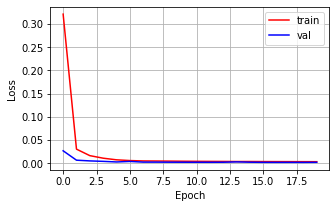

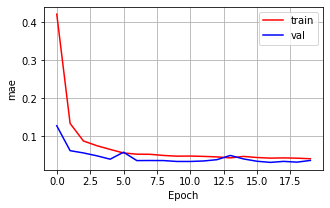

In [366]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.grid()
ax.tick_params()

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history[metrics_reg]), 'r', label='train')
ax.plot(np.sqrt(history.history[f'val_{metrics_reg}']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(metrics_reg)
ax.legend()
ax.grid()
ax.tick_params()

In [367]:
y_pred = model.predict(X_train)
y_pred = [1 if y >= 0 else -1 for y in y_pred]
# y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_train, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,82
1,0,98


In [368]:
loss, acc = model.evaluate(X_test, Y_test,verbose=0) 
# y_t = to_categorical([0 if y == -1 else 1 for y in Y_test])
# loss, acc = model.evaluate(X_test, y_t, verbose=0)
print(f"Test Loss ={loss}\nTest Accuracy = {acc}")

Test Loss =2.0012728214263915
Test Accuracy = 1.0033851861953735


In [350]:
y_pred = model.predict(X_test)
y_pred = [1 if y >= 0 else -1 for y in y_pred]
# y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,40
1,0,40


In [351]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.500
Recall = 1.000


#### Models Comparison

In [113]:
models = []
models.append(('KNN',KNeighborsClassifier()))
models.append(('Tree',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(kernel='rbf',gamma=3)))

In [118]:
names = []
results = []
means = []
sdevs = []
scoring = 'roc_auc'

In [119]:
for name,model in models:
    kfold = StratifiedKFold(n_splits=3,random_state=1)
    cv_results = cross_val_score(model,X2,Y,cv=kfold,scoring=scoring)
    results.append(cv_results)
    means.append(cv_results.mean())
    sdevs.append(cv_results.std())
    names.append(name)

In [122]:
df1 = pd.DataFrame()
df1['name'] = names
df1[f'mean {scoring}'] = means
df1[f'{scoring} std dev'] = sdevs
df1

,name,mean accuracy,roc_auc std dev
0,KNN,0.565812,0.054491
1,Tree,0.480053,0.057326
2,NB,0.514329,0.049321
3,SVM,0.430082,0.041701


Text(0, 0.5, 'Test Accuracy Rate')

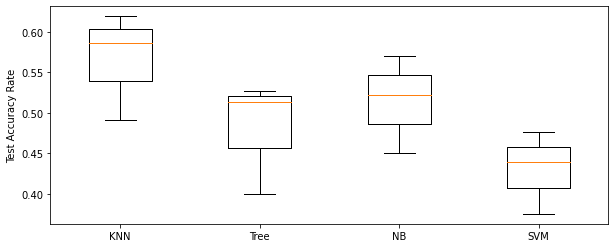

In [123]:
plt.figure(figsize=(10,4))
plt.boxplot(results)
plt.xticks(range(1,5),names)
plt.ylabel(f'Test {scoring} Rate')